In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence 


import os, errno
import sys
from tqdm import trange

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F


## Load Files

In [11]:
def filelist(root):
    """Return a fully-qualified list of filenames under root directory; sort names alphabetically."""
    allfiles = []
    for path, subdirs, files in os.walk(root):
        for name in files:
            allfiles.append(os.path.join(path, name))
    return sorted(allfiles)

## Retrieve Data From Files

In [12]:
docs = []
filenames = filelist('data')

for file in filenames:
        if file.endswith(".qrm"):
            with open(file, 'r') as f:
                contents = f.readlines()
                len_x = contents[1].strip() # Number of points
                step = contents[2].strip()  # Delta time 
                dat = np.array([entry.strip() for entry in contents[3:]]).astype('float64') # Signal Trace
                docs.append((len_x, step, dat))   

In [13]:
data = pd.DataFrame(docs, columns = ['Num_Points', 'delta_Time', 'Signal_Trace'])
data[['Num_Points', 'delta_Time']] = data[['Num_Points', 'delta_Time']].apply(pd.to_numeric)

In [14]:
data.head(2)

,Num_Points,delta_Time,Signal_Trace
0,48039,1.5,"[-0.764239, -0.763441, -0.762922, -0.762684, -..."
1,18602,1.5,"[-0.034912, -0.036457, -0.038145, -0.041018, -..."


## Combine Traces 

Remove first 200 points

In [15]:
traces = []
for i in range(len(data['Signal_Trace'])):
    traces.append(data.iloc[i]['Signal_Trace'][200:])
flat_trace = list(np.concatenate(traces).flat)

## Define Number of Outputs

In [45]:
num_outputs = 20

## Window Data

In [46]:
def split_trace(sequence, n_steps, n_output):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-n_output:
            break

        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+n_output]

        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [47]:
Xs, ys = split_trace(flat_trace, 100, num_outputs)

## Train Test Split

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(Xs, ys, test_size=0.20)

## Scale Data

In [49]:
scaler = StandardScaler() # creates the scaler
scaler.fit(X_train)
x_train = scaler.transform(X_train)
x_test = scaler.transform(X_test)

In [50]:
x_test.shape

(187414, 100)

## Reshape

In [51]:
def reshape_series(series):
    series = np.transpose(series)
    return series.reshape(series.shape[0],series.shape[1], 1)

In [52]:
x_train = reshape_series(x_train)
y_train = reshape_series(Y_train)
x_test = reshape_series(x_test)
y_test = reshape_series(Y_test)

In [53]:
x_train.shape

(100, 749654, 1)

## Initialize Data for Model

In [54]:
#dataset
from torch.utils.data import Dataset

In [55]:
class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

In [56]:
dataset = timeseries(x_train,y_train)
test_dataset = timeseries(x_test,y_test)

In [57]:
dataset.x.shape

torch.Size([100, 749654, 1])

In [67]:
train_loader = DataLoader(dataset,shuffle=False,batch_size=200)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=200)

## Define LSTM Encoder and Decoder (Multistep Prediction)

In [59]:
# neural network
from torch import nn

class lstm_encoder(nn.Module):
    ''' Encodes a time series sequence '''
    
    def __init__(self, input_size=1, hidden_size=5, num_layers=1):

        super(lstm_encoder, self).__init__()
        self.input_size = input_size # the number of features in the input X
        self.hidden_size = hidden_size # the number of features in the hidden state h
        self.num_layers = num_layers # number of recurrent layers 
        
        # define an LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers)
        
    def forward(self, x):
        output, self.hidden = self.lstm(x.view(x.shape[0], x.shape[1], self.input_size))
        
        return output, self.hidden   # hidden gives the hidden state and cell state for the last element in the sequence 
                                     # give this to decoder
    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))
    
        

In [60]:
class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    
    def __init__(self, input_size=1, hidden_size=5, num_layers=1):

        super(lstm_decoder, self).__init__()
        self.input_size = input_size   # the number of features in the input X
        self.hidden_size = hidden_size # the number of features in the hidden state h
        self.num_layers = num_layers   # number of recurrent layers

        # Define LSTM layer and Linear layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, input_size)       
    
    
    def forward(self, x, encoder_hidden_states):
        output, self.hidden = self.lstm(x.unsqueeze(0), encoder_hidden_states)
        output = self.linear(output.squeeze(0))     
        
        return output, self.hidden


## Define Model

In [61]:
class lstm_seq2seq(nn.Module):
    ''' train LSTM encoder-decoder and make predictions '''
    
    def __init__(self, input_size=1, hidden_size=5):

        super(lstm_seq2seq, self).__init__()

        self.input_size = input_size   # number of expected features in the input X
        self.hidden_size = hidden_size # number of features in the hidden state h
        
        # Encoder and decoder
        self.encoder = lstm_encoder(input_size=input_size, hidden_size=hidden_size)
        self.decoder = lstm_decoder(input_size=input_size, hidden_size=hidden_size)
        
    
    def train_model(self, input_tensor, target_tensor, n_epochs, target_len,batch_size,learning_rate = 0.01):
        losses = np.full(n_epochs, np.nan)

        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = nn.MSELoss()

        # calculate number of batch iterations
        n_batches = int(input_tensor.shape[1] / batch_size)

        with trange(n_epochs) as tr:
            for it in tr:
                batch_loss = 0.
  
                for b in range(n_batches):
                    # select data 
                    input_batch = input_tensor[:, b: b + batch_size, :]
                    target_batch = target_tensor[:, b: b + batch_size, :]

                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])

                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)

                    # zero the gradient
                    optimizer.zero_grad()

                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)

                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    for t in range(target_len): 
                        decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                        outputs[t] = decoder_output
                        decoder_input = decoder_output

                    # compute the loss 
                    loss = criterion(outputs, target_batch)
                    batch_loss += loss.item()

                    # backpropagation
                    loss.backward()
                    optimizer.step()

                # loss for epoch 
                batch_loss /= n_batches 
                losses[it] = batch_loss

                # progress bar 
                tr.set_postfix(loss="{0:.3f}".format(batch_loss))

        return losses

        
    def predict(self, input_tensor, target_len):
        
        # encode input_tensor
        input_tensor = input_tensor.unsqueeze(1)     # add in batch size of 1
        encoder_output, encoder_hidden = self.encoder(input_tensor)

        # initialize tensor for predictions
        outputs = torch.zeros(target_len, input_tensor.shape[2])

        # decode input_tensor
        decoder_input = input_tensor[-1, :, :]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output.squeeze(0)
            decoder_input = decoder_output
            
        np_outputs = outputs.detach().numpy()
        
        return np_outputs


## Train model

In [164]:
# specify model parameters and train
model1 = lstm_seq2seq(input_size=1, hidden_size=5)
model2 = lstm_seq2seq(input_size=1, hidden_size=15)
model3 = lstm_seq2seq(input_size=1, hidden_size=50)

In [165]:
print(model)

lstm_seq2seq(
  (encoder): lstm_encoder(
    (lstm): LSTM(1, 50)
  )
  (decoder): lstm_decoder(
    (lstm): LSTM(1, 50)
    (linear): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [168]:
models = [model1, model2, model3]
learning_rate = [0.1, 0.01, .001]
hiddensizes = [5, 15, 50]

In [ ]:
j = 0 
for hs in hiddensizes:
    for lr in learning_rate:
        model = lstm_seq2seq(input_size=1, hidden_size=hs)
        print(f'Model Details - Hidden Size {hs} \t Learning Rate: {lr}')
        train_loss = model.train_model(dataset.x, dataset.y, n_epochs = 4, target_len = num_outputs, batch_size = 200, learning_rate = lr)
        print(f'Training Loss: {train_loss}')
        valid_mse = 0.0
        valid_mae = 0.0
        val_preds = []
        for i in range(len(test_dataset)):
            x_t = test_dataset.x[:, i, :]
            Y_pred = model.predict(x_t, target_len = num_outputs)
            # Calculate MAE
            valid_mae += mean_absolute_error(Y_pred,y_test[:,i])
            # Calculate MSE
            valid_mse += mean_squared_error(Y_pred, y_test[:,i])
            val_preds.append(Y_pred)
    
        torch.save(model, 'lstm_single_output_1000_epochs')
        print(f'\t\t Validation MSE: {valid_mse/len(test_dataset)} \tValidation MAE: {valid_mae/len(test_dataset)}')
        print()
    j += 1

Model Details - Hidden Size 5 	 Learning Rate: 0.1


100%|██████████| 4/4 [04:20<00:00, 65.09s/it, loss=0.005]


Training Loss: [0.00306034 0.02203501 0.00465936 0.00454592]
		 Validation MSE: 0.11315185738503292 	Validation MAE: 0.2993251335491486

Model Details - Hidden Size 5 	 Learning Rate: 0.01


100%|██████████| 4/4 [04:20<00:00, 65.10s/it, loss=0.002]


Training Loss: [0.00390237 0.00314948 0.00249444 0.00204344]
		 Validation MSE: 0.001445489014961132 	Validation MAE: 0.025522029591720563

Model Details - Hidden Size 5 	 Learning Rate: 0.001


100%|██████████| 4/4 [04:20<00:00, 65.18s/it, loss=0.002]


Training Loss: [0.00190571 0.00178936 0.00172285 0.00167133]
		 Validation MSE: 0.0011930064767995653 	Validation MAE: 0.023323884960540765

Model Details - Hidden Size 15 	 Learning Rate: 0.1


100%|██████████| 4/4 [07:15<00:00, 108.95s/it, loss=18.790]


Training Loss: [2.59500879e-03 1.99801700e-03 2.18971339e+01 1.87895934e+01]
		 Validation MSE: 54.375362987402625 	Validation MAE: 6.601802958952363

Model Details - Hidden Size 15 	 Learning Rate: 0.01


 50%|█████     | 2/4 [04:57<04:58, 149.08s/it, loss=33.771]

## Plots

In [37]:
def plot_train_test_results(lstm_model, Xtrain, Ytrain, Xtest, Ytest, unscaled_xtrain, unscaled_xtest, num_rows = 4):

    # input window size
    iw = Xtrain.shape[0]
    ow = Ytest.shape[0]

    # figure setup 
    num_cols = 2
    num_plots = num_rows * num_cols

    fig, ax = plt.subplots(num_rows, num_cols, figsize = (10, 13))

    # plot training/test predictionsabs
    for ii in range(num_rows):
        # train set
        xt = reshape_series(unscaled_xtrain)
        X_train_plt = Xtrain[:, ii, :]
        Y_train_pred = lstm_model.predict(torch.from_numpy(X_train_plt).type(torch.Tensor), target_len = ow)

        ax[ii, 0].plot(np.arange(0, iw), xt[:, ii, 0], 'k', linewidth = 2, label = 'Input')
        ax[ii, 0].plot(np.arange(iw - 1, iw + ow), np.concatenate([[xt[-1, ii, 0]], Ytrain[:, ii, 0]]),
                     color = (0.2, 0.42, 0.72), linewidth = 2, label = 'Target')
        ax[ii, 0].plot(np.arange(iw - 1, iw + ow),  np.concatenate([[xt[-1, ii, 0]], Y_train_pred[:, 0]]),
                     color = (0.76, 0.01, 0.01), linewidth = 2, label = 'Prediction')
        ax[ii, 0].set_xlim([0, iw + ow - 1])
        ax[ii, 0].set_xlabel('$t$')
        ax[ii, 0].set_ylabel('$y$')

        # test set
        xt = reshape_series(unscaled_xtest)
        X_test_plt = Xtest[:, ii, :]
        Y_test_pred = lstm_model.predict(torch.from_numpy(X_test_plt).type(torch.Tensor), target_len = ow)
        
        ax[ii, 1].plot(np.arange(0, iw), xt[:, ii, 0], 'k', linewidth = 2, label = 'Input')
        ax[ii, 1].plot(np.arange(iw - 1, iw + ow), np.concatenate([[xt[-1, ii, 0]], Ytest[:, ii, 0]]),
                     color = (0.2, 0.42, 0.72), linewidth = 2, label = 'Target')
        
        ax[ii, 1].plot(np.arange(iw - 1, iw + ow), np.concatenate([[xt[-1, ii, 0]], Y_test_pred[:, 0]]),
                      color = (0.76, 0.01, 0.01), linewidth = 2, label = 'Prediction')
        ax[ii, 1].set_xlim([0, iw + ow - 1])
        ax[ii, 1].set_xlabel('$t$')
        ax[ii, 1].set_ylabel('$y$')
        
        # Labels
        if ii == 0:
            ax[ii, 0].set_title('Train')

            ax[ii, 1].legend(bbox_to_anchor=(1, 1))
            ax[ii, 1].set_title('Test')

        plt.suptitle('LSTM Encoder-Decoder Prediction Examples', x = 0.445, y = 1.)
        plt.tight_layout()
        plt.subplots_adjust(top = 0.95)
        
        plt.savefig('prediction_examples4.png')


    return 

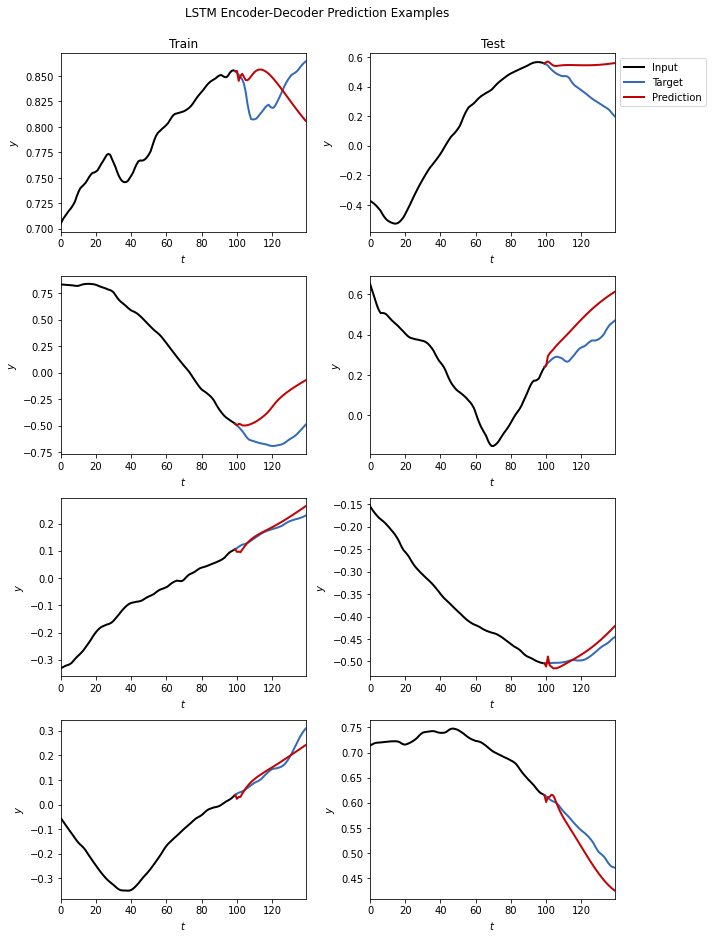

In [42]:
plot_train_test_results(model, x_train, y_train, x_test, y_test, X_train, X_test)

## Plot Loss

In [39]:
def plot_loss(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history
    #val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(loss))
    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.plot(loss, label='MSE')
    ax.legend(loc='upper right')
    plt.tight_layout()
    if file:
        plt.savefig(f"{file}.pdf")

In [40]:
history = torch.tensor(loss)

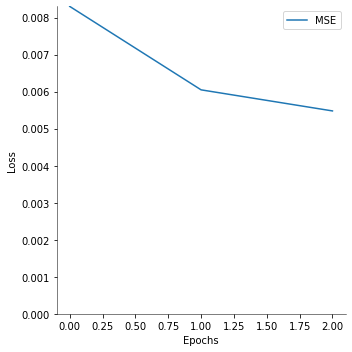

In [41]:
plot_loss(history)